# Predicting Song Popularity

This project aims to predict the popularity of a song by analyzing the affects of independent variables on song popularity.

The dataset was initially sourced from Kaggle and contained data on 2,000 songs from Spotify.  Additional data was procured through API requests to the Spotify API to acquire artist follower count for each song as I suspected that this might have an influence on song popularity. 

Along with follower count, my overall hypothesis was that all my feautures would greatly predict popularity score.

### Data Cleaning

- Two datasets were merged on artist name
- All NaNs were assigned
- Genres were consolidated for consistency and a simplier model
- Dummy variables were created for each genre
- A new feature was created from year released - "years since released" 
- A new feature was created for the total of words in each song title (I thought this may have an influence on popularity as well.)


### Importing necessary libraries

In [14]:

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.metrics import r2_score
pd.options.display.max_columns=100
pd.options.display.max_rows=100

## EDA & Statistical Testing

In [4]:
#reading in cleaned, complete dataset
df=pd.read_csv('song_data_final.csv',index_col=0)


In [5]:
#target variable is popularity score
target=df['Popularity']

#### What does the distribution of the target variable look like?

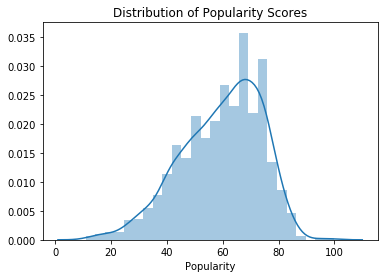

In [6]:
#distribution plot of target variable
#normal distribution, slightly left skewed 
sns.distplot(target)
plt.title('Distribution of Popularity Scores')

plt.show()

#### How do the relationships look between each feature and my target variable?
The relationships mostly appear to be non-linear, I suspect that the effect of one feature may be dependent on another feature. Therefore, interactions and transformations of features should be strongly considered.

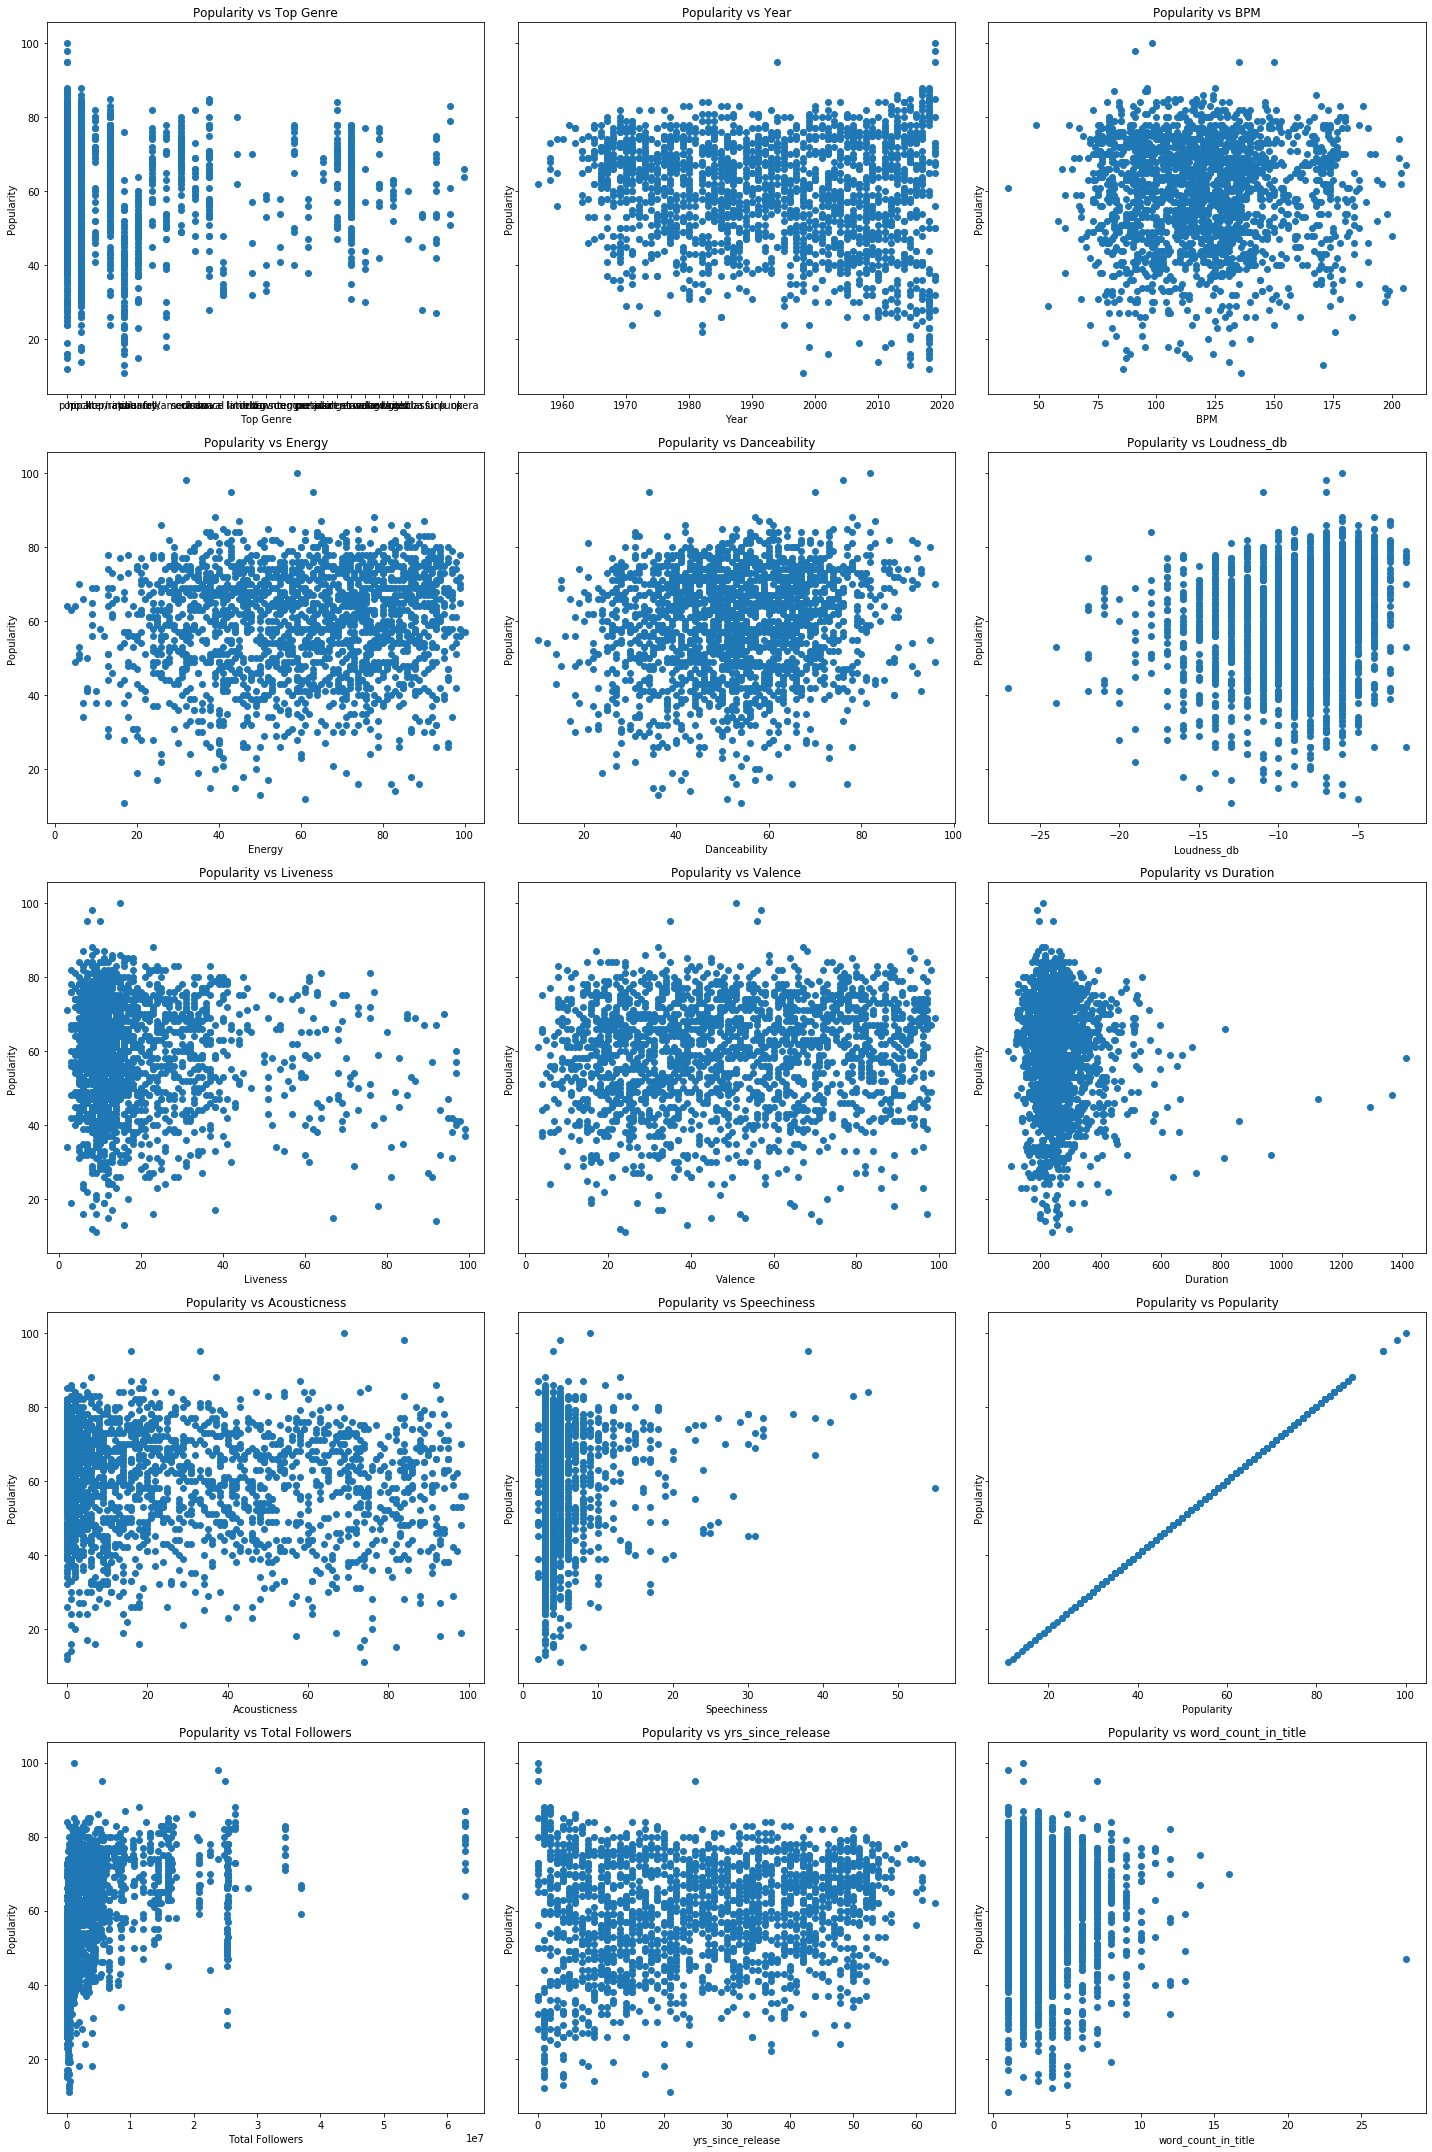

In [7]:
#scatterplots for all x and y relationships (genres not split out)
#mostly non-linear
#interactions should be considered

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,30), sharey=True)

for ax, column in zip(axes.flatten(), df.columns[2:17]):
    ax.scatter(df[column], df['Popularity'], label=column, alpha=1)
    ax.set_title(f'Popularity vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Popularity')

fig.tight_layout()

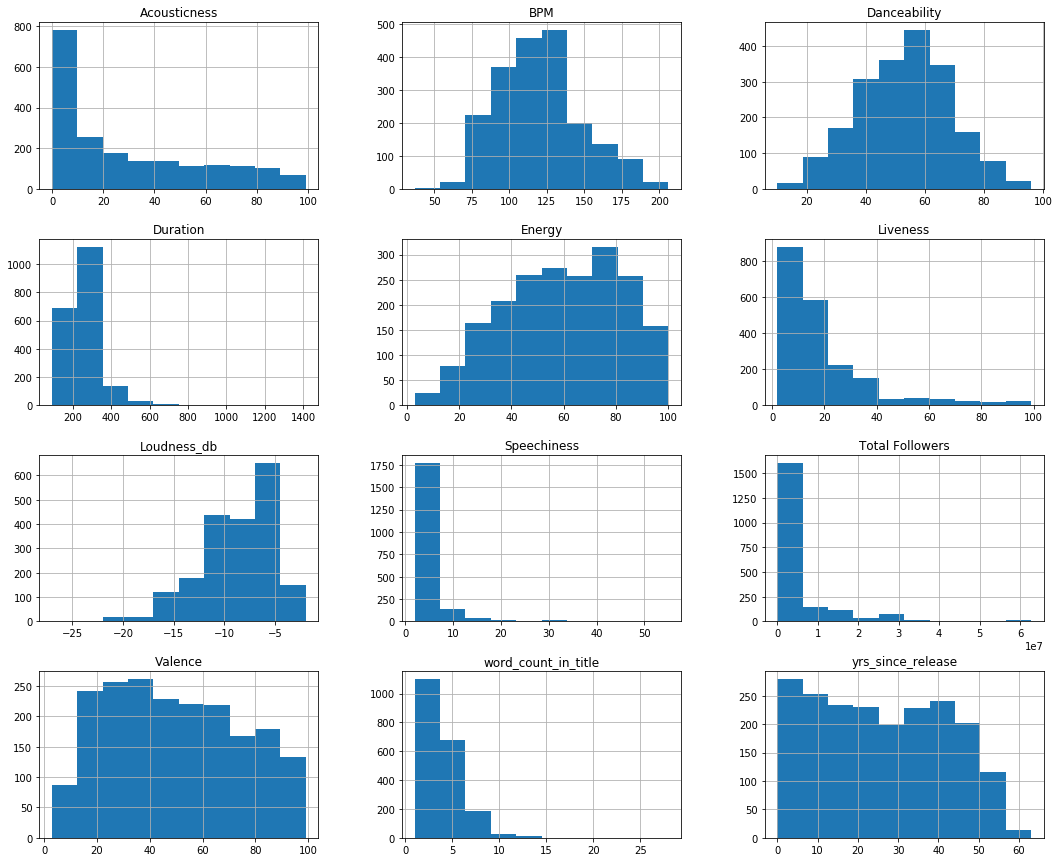

In [9]:
#histogram for all features except genre dummies
#most features are normally distributed
#transformations should be considered
df[['BPM', 'Energy', 'Danceability', 'Loudness_db',
       'Liveness', 'Valence', 'Duration', 'Acousticness', 'Speechiness',
        'Total Followers', 'yrs_since_release',
       'word_count_in_title']].hist(figsize=(18,15))

plt.show()

In [10]:
#dropping categoricals that will not be used
#dummies created for genre
#year was utilized to calculate a new col, yrs_since_released
#title was utilized to caluclate a new col, word_count_in_title
df3=df.drop(columns=['Title','Artist','Top Genre','Year'])

#### What is the correlation between features? between each feature and popularity? 

Loudness and energy are highly correlated so my final model should just include one or an interaction between the two.
No feature appears to be highly correlated with popularity on its own.  

In [11]:
corr=df3.corr()
corr

,BPM,Energy,Danceability,Loudness_db,Liveness,Valence,Duration,Acousticness,Speechiness,Popularity,Total Followers,yrs_since_release,word_count_in_title,Genre_adult standards,Genre_alternative,Genre_blues,Genre_cabaret,Genre_carnaval limburg,Genre_celtic,Genre_chanson,Genre_classic,Genre_country/americana,Genre_dance,Genre_disco,Genre_downtempo,Genre_folk,Genre_funk,Genre_gabba,Genre_hip hop/rap,Genre_indie,Genre_jazz,Genre_latin,Genre_mellow gold,Genre_metal,Genre_opera,Genre_pop,Genre_punk,Genre_reggae,Genre_rock,Genre_singer-songwriter,Genre_soul
BPM,1.000000,0.155437,-0.142008,0.091063,0.015976,0.059158,0.008022,-0.120712,0.085123,-0.004635,-0.069765,-0.011173,-0.027006,-0.033170,0.015995,-0.016387,-0.011788,0.084201,0.014588,-0.024959,-0.025165,-0.058354,0.050500,-0.001953,-0.038754,-0.005458,0.007971,0.056223,-0.024570,-0.017959,0.028792,0.079489,0.000568,-0.028551,0.017242,-0.007237,0.008152,-0.020553,0.022818,-0.009032,-0.024709
Energy,0.155437,1.000000,0.140519,0.735899,0.174229,0.405303,0.021607,-0.665438,0.206048,0.104241,0.058256,-0.147997,0.019736,-0.189693,0.176292,-0.000477,-0.077253,-0.016235,-0.058535,-0.020250,-0.037772,-0.064707,0.106045,0.048342,-0.003373,-0.070791,0.017531,0.050531,0.041483,-0.026677,-0.002867,0.016936,0.028013,0.030581,-0.025981,-0.040733,0.034246,-0.023413,0.053716,-0.008355,-0.036240
Danceability,-0.142008,0.140519,1.000000,0.045922,-0.102697,0.514556,-0.137026,-0.137172,0.125534,0.145635,0.062953,-0.078809,-0.025032,-0.085609,-0.108869,0.048140,-0.001227,-0.083305,-0.040553,-0.066370,-0.031301,0.022067,0.077573,0.107343,-0.010140,-0.030554,0.046282,0.001601,0.175565,0.001530,0.019047,0.014596,0.031973,-0.043719,-0.030373,0.092282,-0.058179,0.136480,-0.068324,-0.002475,0.047567
Loudness_db,0.091063,0.735899,0.045922,1.000000,0.098452,0.147376,-0.057941,-0.452560,0.125403,0.166836,0.195424,-0.344729,-0.032545,-0.180936,0.174842,-0.032391,-0.074779,0.004124,-0.093234,-0.009852,-0.042840,-0.018779,0.044434,-0.012759,-0.002923,-0.050186,-0.006561,0.030486,0.076813,0.002809,-0.009064,0.028485,0.046617,0.047839,0.017465,0.072449,0.030383,-0.022836,-0.077836,0.008903,0.044463
Liveness,0.015976,0.174229,-0.102697,0.098452,1.000000,0.050737,0.032164,-0.046433,0.092656,-0.111654,-0.008360,-0.019238,0.068774,0.016281,0.008087,0.011824,0.015054,0.027553,-0.007823,0.085379,0.006677,0.040822,-0.002884,0.028798,-0.009409,-0.034862,0.020075,0.014192,0.067975,-0.010920,-0.026834,-0.017044,-0.029193,-0.005506,-0.010439,-0.050174,0.028753,0.017791,0.006827,0.023683,-0.053027
Valence,0.059158,0.405303,0.514556,0.147376,0.050737,1.000000,-0.203973,-0.239968,0.107203,0.096250,-0.072410,0.165665,0.077637,0.036743,-0.072781,0.043981,-0.026321,-0.024002,-0.023810,-0.000153,-0.022373,0.005126,-0.039989,0.094886,-0.039961,-0.067898,0.002700,-0.010075,0.063755,0.004048,0.005588,0.045706,-0.004748,-0.057624,-0.025374,-0.042666,-0.020582,0.090315,0.088971,-0.024011,-0.003630
Duration,0.008022,0.021607,-0.137026,-0.057941,0.032164,-0.203973,1.000000,-0.100368,-0.028251,-0.066938,-0.003373,0.051821,0.021516,-0.114483,0.023187,-0.027719,-0.040074,-0.011700,-0.025551,0.008677,-0.002531,-0.061180,0.011350,0.021019,-0.005522,0.007481,0.078563,-0.020985,-0.006067,-0.082674,0.017212,-0.007267,0.008608,0.048362,-0.001366,-0.044143,-0.019663,-0.016782,0.133308,-0.022892,-0.035332
Acousticness,-0.120712,-0.665438,-0.137172,-0.452560,-0.046433,-0.239968,-0.100368,1.000000,-0.098575,-0.088924,-0.055941,0.134132,0.015333,0.189473,-0.186776,0.031138,0.102422,0.025476,0.091055,0.037441,0.023348,0.083522,-0.104802,-0.047659,-0.007157,0.030313,-0.035097,-0.020613,-0.044197,0.025701,0.013308,0.030021,0.002164,-0.050565,0.052524,0.084944,-0.006708,-0.034313,-0.091510,0.053823,0.043958
Speechiness,0.085123,0.206048,0.125534,0.125403,0.092656,0.107203,-0.028251,-0.098575,1.000000,0.111980,0.128731,-0.054414,-0.023045,-0.056074,-0.004276,0.030734,0.020588,0.009777,0.029691,0.006317,-0.005033,-0.038213,0.020706,0.012179,-0.020314,-0.031087

In [12]:
#perhaps multicollinearity between loudness and energy
#checking correlation for all over .5
#no features appear to be highly correlated with popularity
corr[abs(corr>.50)]

,BPM,Energy,Danceability,Loudness_db,Liveness,Valence,Duration,Acousticness,Speechiness,Popularity,Total Followers,yrs_since_release,word_count_in_title,Genre_adult standards,Genre_alternative,Genre_blues,Genre_cabaret,Genre_carnaval limburg,Genre_celtic,Genre_chanson,Genre_classic,Genre_country/americana,Genre_dance,Genre_disco,Genre_downtempo,Genre_folk,Genre_funk,Genre_gabba,Genre_hip hop/rap,Genre_indie,Genre_jazz,Genre_latin,Genre_mellow gold,Genre_metal,Genre_opera,Genre_pop,Genre_punk,Genre_reggae,Genre_rock,Genre_singer-songwriter,Genre_soul
BPM,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Energy,NaN,1.000000,NaN,0.735899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Danceability,NaN,NaN,1.000000,NaN,NaN,0.514556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Loudness_db,NaN,0.735899,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Liveness,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Valence,NaN,NaN,0.514556,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Acousticness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Speechiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Popularity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#total followers has highest correlation with popularity
corr['Popularity'].sort_values(ascending=False)

Popularity                 1.000000
Total Followers            0.334425
Loudness_db                0.166836
yrs_since_release          0.157486
Danceability               0.145635
Speechiness                0.111980
Genre_alternative          0.108686
Energy                     0.104241
Valence                    0.096250
Genre_soul                 0.090088
Genre_rock                 0.062635
Genre_hip hop/rap          0.054523
Genre_adult standards      0.045496
Genre_folk                 0.042441
Genre_reggae               0.037404
Genre_latin                0.030150
Genre_mellow gold          0.026568
Genre_punk                 0.021250
Genre_jazz                 0.021032
word_count_in_title        0.016657
Genre_disco                0.014305
Genre_dance                0.013337
Genre_opera                0.012105
Genre_blues               -0.001723
BPM                       -0.004635
Genre_funk                -0.011585
Genre_gabba               -0.013274
Genre_pop                 -0

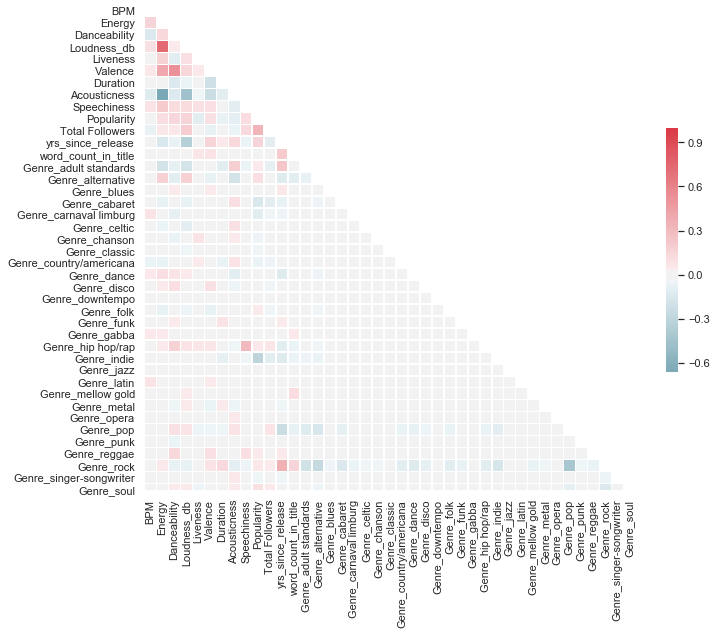

In [67]:
#fig,ax=plt.subplots(figsize=(20,15))

#sns.heatmap(corr)

sns.set(style="white")
# Compute the correlation matrix
#corr = np.abs(data.corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Statistical Tests
- Are genre's that are often lumpted together, significantly different? 
    
#### Two Sample T Test 

Ho: There is no statistical significance between avg popularity for alternative and rock songs

Ha: The average popularity of both genres is different.  

Conclusion: reject Ho

In [17]:
#two sample T test
stats.ttest_ind(df[df['Top Genre']=='rock']['Popularity'],df[df['Top Genre']=='alternative']['Popularity'])


Ttest_indResult(statistic=-3.6624778368437463, pvalue=0.000262775550119648)

#### ANOVA test 

Ho: These genres are not statistically different in relation to popularity

Ha: These genres are statistically different

Conclusion: fail to reject Ho, perhaps all three genres do not to be included in the final model

In [18]:
#ANOVA 
#these genres are not statistically different in reference to popularity
pop_popularity=df[df['Top Genre']=='pop']['Popularity']
dance_popularity=df[df['Top Genre']=='dance']['Popularity']
disco_popularity=df[df['Top Genre']=='disco']['Popularity']
stat,pval = stats.f_oneway(pop_popularity,dance_popularity,disco_popularity)
stat,pval

(0.47549761031567406, 0.621881510819406)

## Modeling 

In [19]:
data=pd.read_pickle('data.pkl')

In [20]:
#not scaled or transformed data
data.rename(columns={'Total Followers':'Artist_Followers','Genre_adult standards':'Genre_adult_standards','Genre_carnaval limburg':'Genre_carnaval_limburg','Genre_mellow gold':'Genre_mellow_gold','Genre_hip_hop/rap':'Genre_hip_hop_rap','Genre_country/americana':'Genre_country_americana','Genre_singer-songwriter':'Genre_singer_songwriter'},inplace=True)

In [23]:
data.columns

Index(['BPM', 'Energy', 'Danceability', 'Loudness_db', 'Liveness', 'Valence',
       'Duration', 'Acousticness', 'Speechiness', 'Popularity',
       'Artist_Followers', 'yrs_since_release', 'word_count_in_title',
       'Genre_adult_standards', 'Genre_alternative', 'Genre_blues',
       'Genre_cabaret', 'Genre_carnaval_limburg', 'Genre_celtic',
       'Genre_chanson', 'Genre_classic', 'Genre_country_americana',
       'Genre_dance', 'Genre_disco', 'Genre_downtempo', 'Genre_folk',
       'Genre_funk', 'Genre_gabba', 'Genre_hip hop/rap', 'Genre_indie',
       'Genre_jazz', 'Genre_latin', 'Genre_mellow_gold', 'Genre_metal',
       'Genre_opera', 'Genre_pop', 'Genre_punk', 'Genre_reggae', 'Genre_rock',
       'Genre_singer_songwriter', 'Genre_soul'],
      dtype='object')

In [25]:
#Per EDA, relationship between song audio features and my target appeared to be non-linear
features_to_transform=['BPM','Energy','Danceability','Loudness_db','Liveness','Valence','Duration','Acousticness','Speechiness']

In [26]:
#creating polynomial interactions between song audio elements
polynomial_features= PolynomialFeatures(degree=2)
x_poly=polynomial_features.fit(data[features_to_transform])
x_poly_df=pd.DataFrame(x_poly.transform(data[features_to_transform]),columns=x_poly.get_feature_names(data[features_to_transform].columns))

In [28]:
#dropping duplicates to concat with other features and target variable
x_poly_df.drop(columns=['1','BPM', 'Energy', 'Danceability', 'Loudness_db', 'Liveness',
       'Valence', 'Duration', 'Acousticness', 'Speechiness'],inplace=True)

In [29]:
#datafame of Y, all original features, polynomial transformations of all song audio variables
data3=pd.concat([data,x_poly_df],axis=1)

In [32]:
data3.shape

(1995, 86)

In [48]:
data3.columns

Index(['BPM', 'Energy', 'Danceability', 'Loudness_db', 'Liveness', 'Valence',
       'Duration', 'Acousticness', 'Speechiness', 'Popularity',
       'Artist_Followers', 'yrs_since_release', 'word_count_in_title',
       'Genre_adult_standards', 'Genre_alternative', 'Genre_blues',
       'Genre_cabaret', 'Genre_carnaval_limburg', 'Genre_celtic',
       'Genre_chanson', 'Genre_classic', 'Genre_country_americana',
       'Genre_dance', 'Genre_disco', 'Genre_downtempo', 'Genre_folk',
       'Genre_funk', 'Genre_gabba', 'Genre_hip hop/rap', 'Genre_indie',
       'Genre_jazz', 'Genre_latin', 'Genre_mellow_gold', 'Genre_metal',
       'Genre_opera', 'Genre_pop', 'Genre_punk', 'Genre_reggae', 'Genre_rock',
       'Genre_singer_songwriter', 'Genre_soul', 'BPM^2', 'BPM Energy',
       'BPM Danceability', 'BPM Loudness_db', 'BPM Liveness', 'BPM Valence',
       'BPM Duration', 'BPM Acousticness', 'BPM Speechiness', 'Energy^2',
       'Energy Danceability', 'Energy Loudness_db', 'Energy Liveness',

In [36]:
#setting target and features for models
target_final=data3['Popularity']
features_final=data3.drop(columns='Popularity')

In [37]:
#test train split of final complete dataset with transformed variables
x_train, x_test, y_train, y_test = train_test_split(features_final, target_final, random_state=32,test_size=0.2)


In [38]:
#scaler for all x train and x test variables 
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled =pd.DataFrame(data=scaler.transform(x_train), columns=features_final.columns)
x_test_scaled =pd.DataFrame(data=scaler.transform(x_test), columns=features_final.columns)

#### Model 1
- one feature 'artist_followers' to predict popularity
- scaled feature 
- not transformed 

Takeaways: This was the highest correlated original feature, the model did not perform well.

In [46]:
#baseline model, one feature - not transformed
one_feat=['Artist_Followers']
lm_one = LinearRegression()

lm_one = lm_one.fit(x_train_scaled[one_feat], y_train)

y_pred_lm_one=lm_one.predict(x_train_scaled[one_feat])

train_rmse_lm_one = np.sqrt(metrics.mean_squared_error(y_train, y_pred_lm_one))

y_pred_test_lm_one = lm_one.predict(x_test_scaled[one_feat])

test_rmse_lm_one = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_lm_one))


print("Train RMSE",(train_rmse_lm_one), "Test RMSE: ", (test_rmse_lm_one))
print ("R squared:", lm_one.score(x_test_scaled[one_feat], y_test))

Train RMSE 13.62929279821175 Test RMSE:  13.122795454623718
Score: 0.09626134685727272


#### Model 2
- all features (85) included in model
- all transformed/interaction song elements
- all original features (un-transformed)

Takeaways: The model performed considerably better with the combination of original feautures and interactions.  However, 85 features is a bit too much for this dataset, so features need to be eliminated.  

In [49]:

lm_two = LinearRegression()

lm_two = lm_two.fit(x_train_scaled, y_train)

y_pred_lm_two=lm_two.predict(x_train_scaled)

train_rmse_lm_two = np.sqrt(metrics.mean_squared_error(y_train, y_pred_lm_two))

y_pred_test_lm_two = lm_two.predict(x_test_scaled)

test_rmse_lm_two = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_lm_two))


print("Train RMSE", train_rmse_lm_two, "Test RMSE: ", test_rmse_lm_two)
print ("R squared:", lm_two.score(x_test_scaled, y_test))

Train RMSE 11.674108004991659 Test RMSE:  11.83547054321551
R squared: 0.2648749934756638


#### Model 3

- Recursive wrapper method of feature selection applied
- 46 features selected


Takeaways: Improved the model slightly from the last model, utilizing only 46 features instead of 85.


In [51]:
#model 3 with selected features as determined by RFECV 
#recursive wrapper method - feature selection

from sklearn.feature_selection import RFECV
ols = linear_model.LinearRegression()

# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(x_train_scaled, y_train)

#creating lists of selected/removed feature names
selected_columns = x_train_scaled.columns[selector.support_]
removed_columns = x_train_scaled.columns[~selector.support_]

lm_three = LinearRegression()

lm_three = lm_three.fit(x_train_scaled[selected_columns], y_train)

y_pred_lm_three=lm_three.predict(x_train_scaled[selected_columns])

train_rmse_lm_three = np.sqrt(metrics.mean_squared_error(y_train, y_pred_lm_three))

y_pred_test_lm_three = lm_three.predict(x_test_scaled[selected_columns])

test_rmse_lm_three = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_lm_three))


print("Train RMSE", train_rmse_lm_three, "Test RMSE: ", test_rmse_lm_three)
print ("R Squared:", lm_three.score(x_test_scaled[selected_columns], y_test))

Train RMSE 11.79488031456517 Test RMSE:  11.827278406499781
R Squared: 0.2658923016310828


#### Model 4
- Lasso feature selection applied on 46 recurvise wrapper selected features

Takeaways: This model performed better, 43 features were selected

In [58]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1, normalize=False)

lasso.fit(x_train_scaled[selected_columns],y_train)

y_train_pred_lasso = lasso.predict(x_train_scaled[selected_columns])
y_pred_lasso = lasso.predict(x_test_scaled[selected_columns])

train_rmse_lasso = metrics.mean_absolute_error(y_train, y_train_pred_lasso)
test_rmse_lasso = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
print('Training Error: '+ str(train_rmse_lasso) )
print('Testing Error: '+ str(test_rmse_lasso) )

print("R Squared:", lasso.score(x_test_scaled[selected_columns],y_test))

Training Error: 9.58024751131949
Testing Error: 11.631622670900851
R Squared: 0.28997972722295406


,0
Genre_indie,-4.135311
Danceability Duration,-3.512693
Danceability^2,-1.936331
Genre_pop,-1.918394
Acousticness Speechiness,-1.918193
Genre_rock,-1.868481
Energy Speechiness,-1.857362
Duration Speechiness,-1.713904
Genre_cabaret,-1.711373
Danceability Speechiness,-1.650424


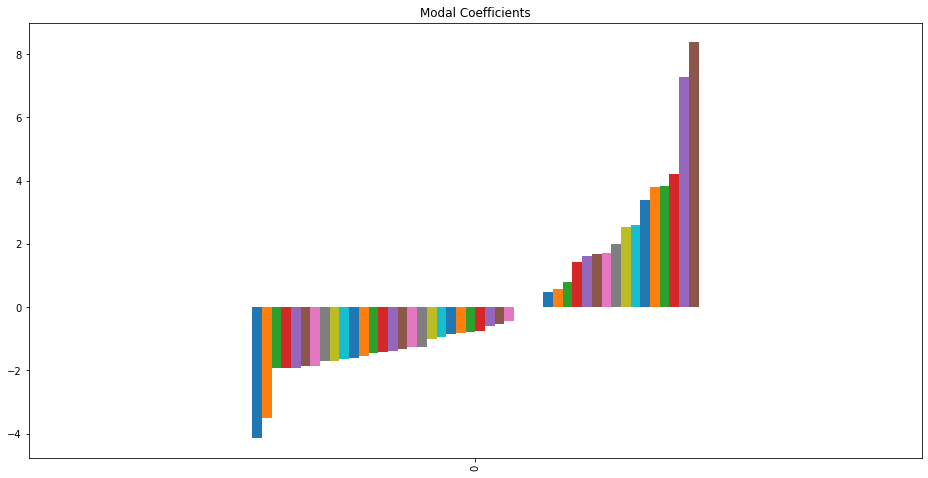

In [53]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = x_train_scaled[selected_columns].columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))
lasso_coef01.T

#### Model 5 - final model

- Lasso feature selection used on all 85 features 
- Model ran with Lasso selected features
- 34 features selected

Takeaways:  This model performed the best in terms of predicting similarly on test/train data, and highest r-squared with the least amount of features.



In [61]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import warnings
warnings.filterwarnings('ignore')

sel=SelectFromModel(LassoCV())
sel.fit(x_train_scaled,y_train)


selected_feats=x_train_scaled.columns[(sel.get_support())]
print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel.estimator_.coef_ == 0)))


total features: 85
selected features: 34
features with coefficients shrank to zero: 51


In [62]:
#Model 5 linear regression with lasso only selected features
lm_five = LinearRegression()

lm_five = lm_five.fit(x_train_scaled[selected_feats], y_train)

y_pred_lm_five=lm_five.predict(x_train_scaled[selected_feats])

train_rmse_lm_five = np.sqrt(metrics.mean_squared_error(y_train, y_pred_lm_five))

y_pred_test_lm_five = lm_five.predict(x_test_scaled[selected_feats])

test_rmse_lm_five = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_lm_five))


print("Train RMSE", train_rmse_lm_five, "Test RMSE: ", test_rmse_lm_five)
print ("R Squared:", lm_five.score(x_test_scaled[selected_feats], y_test))

Train RMSE 11.864271670187073 Test RMSE:  11.688024481674052
R Squared: 0.28307724716525395


In [64]:
#coefficients of this model

coef_df=pd.DataFrame(lm_five.coef_)
dftest=pd.DataFrame(selected_feats)
coeff_df=pd.concat([dftest,coef_df],axis=1)
coeff_df.columns='Feature','Coef'

coeff_df.sort_values(by='Coef',ascending=False)

,Feature,Coef
1,Artist_Followers,3.913116
2,yrs_since_release,3.438344
5,Genre_alternative,1.595203
0,Danceability,1.451896
29,Loudness_db Duration,1.077671
14,Genre_folk,0.975183
24,BPM Loudness_db,0.839291
26,Energy Loudness_db,0.819347
22,Genre_soul,0.698843
33,Speechiness^2,0.644560


#### Scatterplot of the final model's predictions vs true values

Some predictions were slighly off but there is a general pattern to the plots.

<function matplotlib.pyplot.show(*args, **kw)>

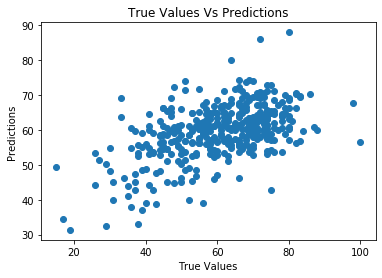

In [66]:
plt.scatter(y_test, y_pred_test_lm_five)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True Values Vs Predictions")
plt.show

### Concluding Thoughts

My final model is not very predictive of song popularity with an R-Squared value of 0.2830.  As such, only 28% of the amount of variation in song popularity is explained by the model.  

To increase the predictive power of my model, I would like to try further degrees of polynomial transformations to perhaps find better interactions among my features. 

Additionally, it may also be the case that another type of model would be better suited to predict the popularity of songs.